In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import ct_sm
from cosmoTransitions import pathDeformation
from cosmoTransitions import transitionFinder
%matplotlib inline
from collections import namedtuple
from collections import OrderedDict
import sys


def findTn(model, critobj, low_id, high_id, nucleationCrit=140.,makeMinPlot=False):
    """
    Now for a given parameter space point we can find the nucleation temperature by scanning around the relevant critical temperature
    and finding T_n such that S_3/T_n =140 (for the 3D case).
    
    Inputs:
        critobj: object containing the critical temperatures and vevs for a particular phase transition, 
        computed using model.calcTcTrans()
        nucleationCrit: Nucleation temperature is defined by S/T = nucleationCrit. 
    Returns:
        Tnuc: nucleation temperature
        S/T: value of the action at T=Tnuc. If Tnuc is physical, then S/T = nucleationCrit
    """
    # First, check that the transition is first order!
    if critobj['trantype']!=1:
        return -2,-2
    # A large number used to denome some kinds of error
    hugenum = 1e99
    #The critical temperature you want to start at 
    Tcrit = critobj['Tcrit']

    #The lowest temperature to consider; make sure it's higher than the temp where the high-T phase disappears
    highphase_id = high_id #critobj['high_phase']
    lowphase_id = low_id #critobj['low_phase']
    Tmin = model.phases[highphase_id].T[0]
    
    #The largest temperature to consider:
    Tmax = Tcrit-0.0001
    print "Tmin = ",Tmin, " Tmax = ", Tmax
    assert Tmin < Tmax
    #Tmax = transitionFinder._maxTCritForPhase(model.phases, model.phases[highphase_id])
    # Function that returns S/T for a given temperature T
    def actionFunction(T):
        V = lambda x: model.Vtot(x,T)
        gradV = lambda x: model.gradV(x,T)
        lowmin = scipy.optimize.fmin(V,model.phases[lowphase_id].valAt(T),disp=0,ftol=1e-8)
        print model.phases[highphase_id].valAt(T)
        highmin = scipy.optimize.fmin(V,[0.],disp=0,ftol=1e-8)
        #highmin = scipy.optimize.fmin(V,model.phases[highphase_id].valAt(T),disp=0,ftol=1e-8)
        # Make sure the minima are not the same
        mineps = np.linalg.norm(lowmin-highmin)/np.linalg.norm(lowmin+highmin)
        if mineps < 1e-2:
            return hugenum
        
    
        #assert V(lowmin) < V(highmin)
        if V(lowmin) > V(highmin):
            print "Vlow > Vhigh!"
            print "T = ", T
            print "dV = " ,V(lowmin)-V(highmin)
            print "low: ",lowmin, V(lowmin)
            print "high: ", highmin, V(highmin)
            return hugenum
        """
        t = np.linspace(-0.2,0.2,100)
        linphi = [highmin+ti*(lowmin-highmin) for ti in t]
        Vlin = [V(phii) for phii in linphi]
        plt.plot(t,Vlin)
        plt.ylim([-1e4,0])
        plt.show()
        hess_low = model.d2V(lowmin,T)
        hess_high = model.d2V(highmin,T)
        print lowmin, highmin
        print np.linalg.eigvals(hess_low), np.linalg.eigvals(hess_high)
        """
        path = [lowmin,highmin]
        tobj = pathDeformation.fullTunneling(path,V,gradV)
        return tobj.action/max(T,1e-5)-nucleationCrit
    
    # If S(T_min)/Tmin-140 > 0. then try to find the minimum action instead
    afMin = actionFunction(Tmin+1e-2)
    if (afMin > 0. and afMin < hugenum):
        TSmin =  scipy.optimize.fminbound(lambda T: np.fabs(actionFunction(T)),Tmin,Tmax,xtol=1e-3,maxfun=40)
        actFuncMin = actionFunction(TSmin)
        if (actFuncMin > 1.):
            print "Nucleation too slow! S/T > 140!"
            if makeMinPlot:
                Ts = np.linspace(Tmin,Tmax,num=20)
                SoT = [nucleationCrit+actionFunction(T) for T in Ts]
                plt.figure()
                plt.yscale('log')
                plt.plot(Ts,SoT,'b--',linewidth=3.0)
                plt.show()
        
            Tnuc = 1e99
            return Tnuc, actFuncMin+nucleationCrit
    # The pair of minima provided in critobj were not good
    elif afMin == hugenum:
        return -1, -1
        
    # Otherwise find the proper nucleation temperature
    else:
        # Make sure the root is bracketed
        aTmax = actionFunction(Tmax-1e-2)
        aTmin = actionFunction(Tmin+1e-2)
        assert aTmax > 0. and aTmin < 0.
        Tnuc = scipy.optimize.brentq(actionFunction,Tmin+1e-2,Tmax,xtol=1e-5)

    
    print "Tnuc = ",Tnuc #, " actionFunction = ", actionFunction(Tnuc)
    return Tnuc, actionFunction(Tnuc)+nucleationCrit

def calcStrength(critobj):
    if critobj['trantype']==1:
        return np.linalg.norm(critobj['low_vev'])/critobj['Tcrit']
    else:
        return 0




In [2]:
model = ct_sm.sm_eft()

Guesses for mu12 and l1 =  -7849.96 0.11
RG running with initial parameters at the input scale...
Finding the correct parameters at the input scale...
Deviations from desired values before optimization: [-0.025882785025428054, -0.40525850000000002]
Deviations from desired values after optimization: [0.011365129055261667, -0.0094720624999999996]
Final values of mu12, l1 =  -7802.58526892 0.118522908196
Scale set at mu =  246.22
vev =  [ 234.53582764]
mh =  116.494739856


/home/nblinov/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:237: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [3]:
model = ct_sm.sm_eft()

Guesses for mu12 and l1 =  -7849.96 0.11
RG running with initial parameters at the input scale...
Finding the correct parameters at the input scale...
Deviations from desired values before optimization: [-0.025882785025428054, -0.40525850000000002]
Deviations from desired values after optimization: [0.011365129055261667, -0.0094720624999999996]
Final values of mu12, l1 =  -7802.58526892 0.118522908196
Scale set at mu =  246.22
vev =  [ 234.53582764]
mh =  116.494739856


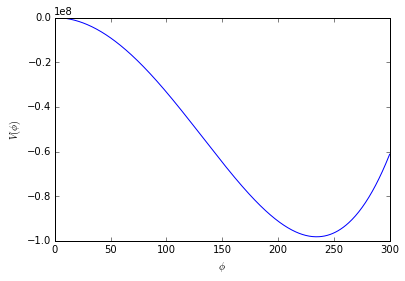

In [9]:
model.plot1d(0,300,T=0)

In [10]:
scipy.optimize.minimize(lambda x: model.Vtot(x,T=0),[200],method='Nelder-Mead')

  status: 0
    nfev: 40
 success: True
     fun: -99569888.418935478
       x: array([ 234.53582764])
 message: 'Optimization terminated successfully.'
     nit: 20

In [11]:
scipy.optimize.fmin(lambda x: model.Vtot(x,T=0),[200])

Optimization terminated successfully.
         Current function value: -99569888.418935
         Iterations: 20
         Function evaluations: 40


array([ 234.53582764])

In [12]:
Vs

NameError: name 'Vs' is not defined

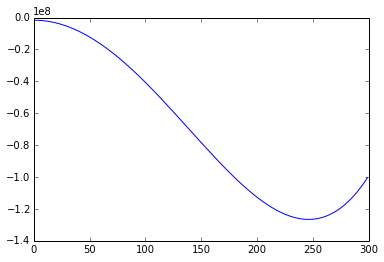

In [6]:
xarray = np.arange(0,300)
Vs = [model.Vtot([x],T=0) for x in xarray]
plt.plot(xarray,Vs)
plt.show()

In [4]:
model.findMinimum()

array([ 246.2199646])

In [6]:
np.sqrt(model.d2V(model.findMinimum(),T=0))

array([[ 124.99979687]])

In [7]:
print model.l1
print model.mu12

0.114382297678
-8619.43094935


In [3]:
print np.sqrt(model.renormScaleSq)

246.22


In [4]:
print model.l1
print model.mu12

0.114382507683
-8619.443781


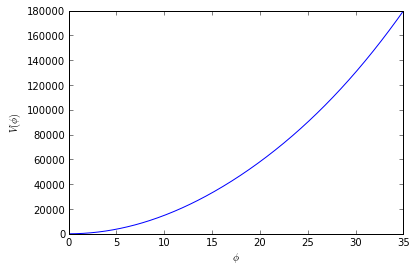

In [5]:
model.plot1d(0,35,T=160)

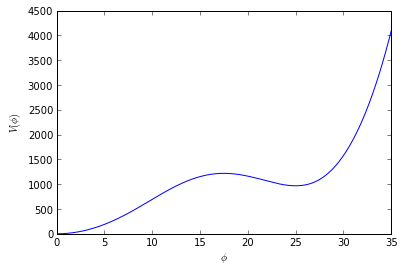

In [6]:
model.plot1d(0,35,T=157.05)

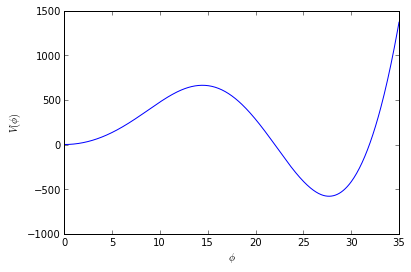

In [7]:
model.plot1d(0,35,T=157.00268228995054)

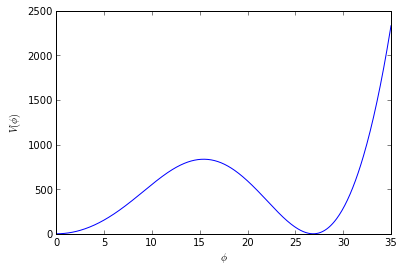

Tracing phase starting at x = [ 246.22000125] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...............................................................................................................................................................
Tracing phase starting at x = [ -2.43750000e-05] ; t = 158.075268216
Tracing minimum down
traceMinimum t0 = 158.075
........................
Tracing minimum up
traceMinimum t0 = 158.075
..............


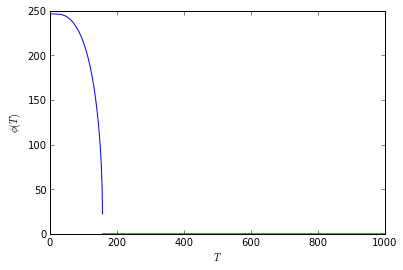

In [9]:
model.plotPhasesPhi()

In [10]:
model.phases

{0: Phase(key=0, X=[[246.2], ..., [22.35]], T=[0, ..., 157.1], dXdT=[[3.891e-20], ..., [-267.1]],
 1: Phase(key=1, X=[[-0.005373], ..., [-9.714e-17]], T=[156.9, ..., 1000], dXdT=[[0.5348], ..., [0.000432]]}

In [11]:
model.calcTcTrans()

[{'Delta_rho': 5296734.1324691772,
  'Tcrit': 157.0193375940774,
  'high_phase': 1,
  'high_vev': array([ 0.00119536]),
  'low_phase': 0,
  'low_vev': array([ 26.86800988]),
  'trantype': 1}]

In [14]:
calcStrength(model.TcTrans[0])

0.17111274506894197

In [15]:
# This fails for some reason!
model.findAllTransitions()

[]

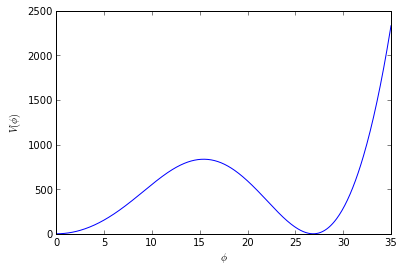

In [16]:
model.plot1d(0,35,T=model.TcTrans[0]['Tcrit'])

In [17]:
# Dumb function works!
findTn(model,model.TcTrans[0],0,1)

Tmin =  156.876075066  Tmax =  157.019237594
[-0.00415109]
Path deformation converged. 1 steps. fRatio = 7.63650e-14
[ 0.00123834]
Path deformation converged. 1 steps. fRatio = 1.94721e-13
[-0.00415109]
Path deformation converged. 1 steps. fRatio = 7.63650e-14
[-0.00415109]
Path deformation converged. 1 steps. fRatio = 7.63650e-14
[ 0.00119593]
Path deformation converged. 1 steps. fRatio = 9.91441e-14
[-0.00414369]
Path deformation converged. 1 steps. fRatio = 7.59535e-14
[ 0.00052119]
Path deformation converged. 1 steps. fRatio = 9.19854e-14
[ 0.00118118]
Path deformation converged. 1 steps. fRatio = 1.24878e-13
[ 0.00124719]
Path deformation converged. 1 steps. fRatio = 1.28319e-13
[ 0.00124719]
Path deformation converged. 1 steps. fRatio = 1.60456e-13
[ 0.00124719]
Path deformation converged. 1 steps. fRatio = 1.60422e-13
[ 0.00124719]
Path deformation converged. 1 steps. fRatio = 6.41675e-14
Tnuc =  157.00268229
[ 0.00124719]
Path deformation converged. 1 steps. fRatio = 1.60422e-1

cosmoTransitions/tunneling1D.py:407: RuntimeWarning: overflow encountered in double_scalars
  r *= 10


(157.00268228995054, 140.01828264765663)

Tracing phase starting at x = [ 246.22000125] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
....................................................................................................................................................................................
Tracing phase starting at x = [ -8.67361738e-19] ; t = 158.074227657
Tracing minimum down
traceMinimum t0 = 158.074
....................................
Tracing minimum up
traceMinimum t0 = 158.074
..........


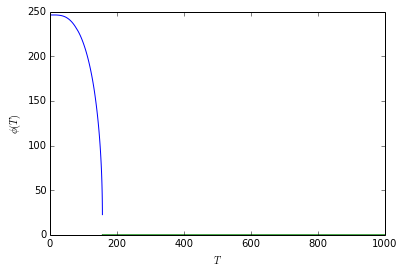

In [8]:
model.plotPhasesPhi()

In [9]:
model.calcTcTrans()

[{'Delta_rho': 5296797.4938716888,
  'Tcrit': 157.01924327607568,
  'high_phase': 1,
  'high_vev': array([ 0.01402706]),
  'low_phase': 0,
  'low_vev': array([ 26.86818748]),
  'trantype': 1}]

In [10]:
calcStrength(model.TcTrans[0])

0.17111397890618119